In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os,re,nltk,difflib
sns.set_style("whitegrid")

def ding():
    os.system('afplay /System/Library/Sounds/Submarine.aiff')

### Choisir le match

In [2]:
# rep="/Users/gilles/Downloads/Traitements_GB/"
rep="/Users/gilles/Github/AMBK-SportsCom/Chaines/Traitements_GB/"
match="FR-AR"
match="FR-NZ"
nFile="%s-fr-GB.xlsx"%match

In [3]:
dfBrut=pd.read_excel(rep+nFile,index_col=0)

In [4]:
df=dfBrut["Transcription Cat Lemme Referent numChaine chaineIndex chaineDep chaineApp".split(" ")].copy()

In [5]:
nbMots=len(df[~df.Cat.isin(["PUN","SENT"])])
print(match,nbMots)

FR-NZ 18211


### Calcul des chaines

In [6]:
maxNumChaine=int(df.numChaine.max())
maxNumChaine

1150

In [7]:
chaines={}
lChaines={}
for num in range(maxNumChaine):
    n=num+1
    dfChaine=df.loc[df.numChaine==n]
    try:
        chaines[n]={"ref":dfChaine.Referent.values[0],"chaine":{}}
        indexMax=int(dfChaine.chaineIndex.max())
        if indexMax not in lChaines:
            lChaines[indexMax]=0
        lChaines[indexMax]+=1
        for ind in range(indexMax):
            i=ind+1
            dfIndex=dfChaine.loc[dfChaine.chaineIndex==i]
            chaines[n]["chaine"][i]=dfIndex[["Cat","Transcription"]].to_dict()
    except:
        print("pb",n,end=", ")
        # display(dfChaine)
print()
print(lChaines)

pb 40, pb 104, pb 106, pb 142, pb 167, pb 179, pb 210, pb 226, pb 231, pb 247, pb 280, pb 293, pb 303, pb 533, pb 579, pb 748, pb 754, pb 1083, pb 1099, 
{2: 222, 1: 694, 3: 86, 10: 7, 5: 25, 4: 49, 6: 18, 7: 14, 8: 10, 11: 2, 9: 3, 14: 1}


#### Calcul de la longueur maximale des chaines

In [8]:
maxLChaines=max(lChaines.keys())
for l in range(maxLChaines):
    if l+1 not in lChaines:
        lChaines[l+1]=0
colors = sns.color_palette('pastel',n_colors=maxLChaines)

#### Nombre de chaines par longueur

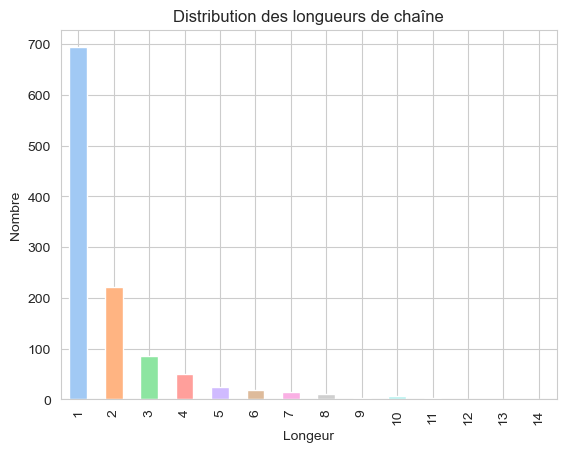

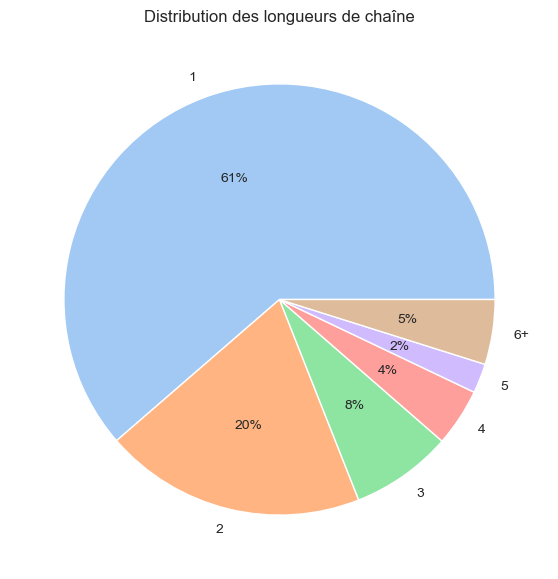

In [9]:
pieCut=5
dfDistLong=pd.DataFrame.from_dict(lChaines,orient="index").sort_index()
dfDistLong.name="Longueur de chaine"
dfDistLong.plot.bar(y=0,color=colors,ylabel="Nombre",xlabel="Longeur",title="Distribution des longueurs de chaîne",legend=False)
plt.savefig("JE-BP-LongChaines-%s.pdf"%match)
dfTemp=dfDistLong[:pieCut].copy()
autres=dfDistLong[pieCut:].sum()
autres.index=["%d+"%(pieCut+1)]
dfTemp=pd.concat([dfTemp,autres])
ax=dfTemp.plot.pie(y=0,colors=colors, autopct='%.0f%%',title="Distribution des longueurs de chaîne",figsize=(7,7),legend=False)
ax.set_ylabel(None)
dfTemp.to_excel("DistLongChaine-%s.xlsx"%match)
plt.savefig("JE-PC-LongChaines-%s.pdf"%match)

#### Nombre de chaines par longueur par référent

In [10]:
refChaines={}
lRefChaines={}#
# print(lRefChaines)
for k,v in chaines.items():
    ref=chaines[k]["ref"]
    chaine=chaines[k]["chaine"]
    if ref not in refChaines:
        refChaines[ref]=[]
        lRefChaines[ref]={i:0 for i in range(1,maxLChaines+1)}
    refChaines[ref].append(chaines[k]["chaine"])
    longueur=max(chaines[k]["chaine"].keys())
    if longueur not in lRefChaines[ref]:
        lRefChaines[ref][longueur]=0
    lRefChaines[ref][longueur]+=1
dfRefChaines=pd.DataFrame.from_dict(lRefChaines).sort_index().T

dfRefChaines["sum"]=dfRefChaines.iloc[:,0:maxLChaines].sum(axis=1)
dfRefChaines=dfRefChaines.sort_values(by='sum',ascending=False)
dfRefChaines=dfRefChaines.drop(columns="sum")
display(dfRefChaines.head())

,1,2,3,4,5,6,7,8,9,10,11,12,13,14
GTF,100,48,16,4,5,2,2,5,0,0,0,0,0,0
GTNZ,77,22,13,3,3,3,3,0,1,0,0,0,0,0
CHRISTIAN,45,0,2,4,2,0,0,0,0,0,0,0,0,0
Bernard,40,5,1,1,1,0,1,0,0,0,0,0,0,0
Christian,33,4,0,1,2,0,0,0,0,0,0,0,0,0


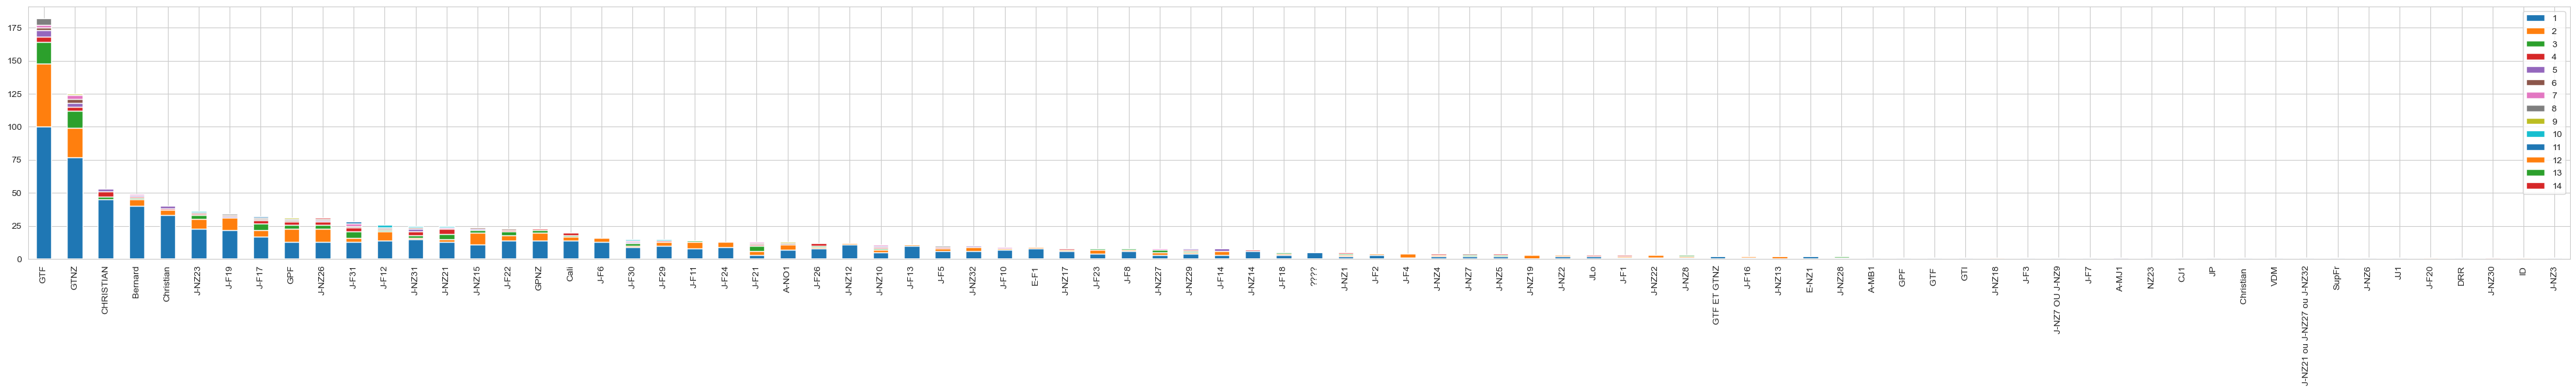

In [11]:
dfRefChaines.plot(kind="bar",stacked=True,figsize=(50,5))
plt.savefig("JE-SB-DistChaines-%s.pdf"%match)

#### Calcul du nombre de reprises par catégorie
- chaineIndex renseignée
- chaineDep différent de root (≠0)

In [12]:
print(match)
catTable=df[(df.chaineIndex.notnull())&(df.chaineDep>0)].groupby("Cat").count()[["Lemme"]].loc["NAM PRO:REL PRO:PER NOM DET:POS PRO:DEM PRO:IND".split(" ")]
display(catTable)
print(catTable.sum())

FR-NZ


,Lemme
Cat,
NAM,67
PRO:REL,157
PRO:PER,595
NOM,81
DET:POS,14
PRO:DEM,14
PRO:IND,1


Lemme    929
dtype: int64


#### Détail des reprises

In [13]:
dfGroupReprises=df[(df.chaineIndex.notnull())&(df.chaineDep>0)].groupby(["numChaine","chaineIndex"])[["Cat","Transcription"]].sum()
dfGroupReprises

Cat Transcription
numChaine chaineIndex                          
1.0       2.0             PRO:DEM          ceux
5.0       2.0             PRO:PER           ils
          3.0          PRO:DEMNOM   cetteéquipe
9.0       2.0             PRO:REL           qui
19.0      2.0                 NOM     capitaine
...                           ...           ...
1147.0    4.0             PRO:PER            je
          5.0             PRO:PER            je
          6.0             PRO:PER            je
          7.0                 NOM          Titi
1149.0    2.0             PRO:PER          nous

[865 rows x 2 columns]

In [14]:
print(match,len(dfGroupReprises),nbMots,"%2.1f%%"%(len(dfGroupReprises)/nbMots*100))

FR-NZ 865 18211 4.7%


#### Détail des références

In [15]:
dfGroupeReferents=df[(df.chaineIndex.notnull())].groupby(["numChaine","chaineIndex"])[["Cat","Transcription"]].agg(" ".join)
dfGroupeReferents

Cat  \
numChaine chaineIndex                                    
1.0       1.0                                  PRO:DEM   
          2.0                                  PRO:DEM   
2.0       1.0                                      NAM   
3.0       1.0                                      NAM   
4.0       1.0          DET:ART NOM PRP:det NOM PRP NOM   
...                                                ...   
1147.0    8.0              NOM PRP DET:ART NOM PRP NAM   
1148.0    1.0                                      NAM   
1149.0    1.0                      DET:ART NOM PRP NAM   
          2.0                                  PRO:PER   
1150.0    1.0                                      NAM   

                                          Transcription  
numChaine chaineIndex                                    
1.0       1.0                                      ceux  
          2.0                                      ceux  
2.0       1.0                                   Bernard  
3.0       1.0                                 Christian  
4.0       1.0           les champions du monde en titre  
...                                                 ...  
1147.0    8.0          capitaine de l' équipe de France  
1148.0    1.0                                   Bernard  
1149.0    1.0                       l' équipe de France  
          2.0                                      nous  
1150.0    1.0                                   Bernard  

[2050 rows x 2 columns]

In [16]:
print(match,len(dfGroupeReferents),nbMots,"%2.1f%%"%(len(dfGroupeReferents)/nbMots*100))

FR-NZ 2050 18211 11.3%


In [17]:
print(dfGroupeReferents.to_string())

                                                                   Cat                               Transcription
numChaine chaineIndex                                                                                             
1.0       1.0                                                  PRO:DEM                                        ceux
          2.0                                                  PRO:DEM                                        ceux
2.0       1.0                                                      NAM                                     Bernard
3.0       1.0                                                      NAM                                   Christian
4.0       1.0                          DET:ART NOM PRP:det NOM PRP NOM             les champions du monde en titre
5.0       1.0                          DET:ART NOM PRP:det NOM PRP NOM             les champions du monde en titre
          2.0                                                  PRO:PER          

# Rapprochements entre chaines et autres données

In [18]:
import nltk,difflib,re,unidecode

### Sélection du tableau des tours

In [19]:
def getCommType(row):
    if row["PxP"]==1:
        return "Play by play"
    elif row["Color"]==1:
        return "Color commentary"
    else:
        return "Autre"

In [20]:
if match=="FR-AR":
    dfGen=pd.read_csv(rep+"CorrespondancesAction-PlayVsColourVsSupportaire.csv",sep=";")
    
    dfGen.columns="lNum tDeb tFin penalite type event action actComm comm rem1 rem2 err1 err2 commType commTypeCorr".split(" ")
    dTours=dfGen.loc[dfGen.comm.notnull()][["comm","commType","tDeb","tFin"]].to_dict(orient="index")
    lTours=[v for k,v in dTours.items()]
    nTours={}
    for nT,tour in enumerate(lTours):
        if not tour["comm"].startswith("PROB"):
            refComm,comm=tour["comm"].split(" ",1)
            nTours[nT]=(nltk.wordpunct_tokenize(comm), 
                        refComm, tour["commType"], tour["tDeb"], tour["tFin"])

elif match=="FR-NZ" and "fr-GB" in nFile:
    dfGen=pd.read_csv(rep+"Fr-NZ_Tours.csv",sep="\t")
    dfGen["nTour speaker startTime endTime tour nActions PxP Color Supporter".split(" ")]
    dfGen["commType"]=dfGen.apply(getCommType,axis=1)
    dfGen.rename(columns={"tour":"comm","startTime":"tDeb","endTime":"tFin"},errors="raise",inplace=True)
    dTours=dfGen.loc[dfGen.comm.notnull()][["comm","commType","tDeb","tFin","nTour","speaker"]].to_dict(orient="index")
    lTours=[v for k,v in dTours.items()]
    nTours={}
    for nT,tour in enumerate(lTours):
        refComm=str(tour["nTour"])+"-"+tour["speaker"]
        comm=tour["comm"]
        nTours[nT]=(nltk.wordpunct_tokenize(comm), 
                    refComm, tour["commType"], tour["tDeb"], tour["tFin"])
nTours   

{0: (['bonsoir',
   ',',
   'c',
   "'",
   'était',
   'ceux',
   'd',
   "'",
   'hier',
   '.',
   'voici',
   'ceux',
   'd',
   "'",
   'aujourd',
   "'",
   'hui',
   '.'],
  '1-spk1',
  'Color commentary',
  '00:00:36.628000',
  '00:00:40.304000'),
 1: (['nous',
   'sommes',
   'dans',
   'les',
   'vestiaires',
   'de',
   'ce',
   'Millenium',
   'de',
   'Cardiff',
   ',',
   'pour',
   'ce',
   'quarante',
   '-',
   'deuxième',
   'match',
   ','],
  '2-spk1',
  'Color commentary',
  '00:00:40.537000',
  '00:00:44.574000'),
 2: (['de', 'coupe', 'du', 'monde', '.'],
  '3-spk1',
  'Color commentary',
  '00:00:44.975000',
  '00:00:45.959000'),
 3: (['bonsoir', 'Bernard', '.'],
  '4-spk1',
  'Color commentary',
  '00:00:46.488000',
  '00:00:47.191000'),
 4: (['bonsoir', 'Christian', ',', 'bonsoir', 'à', 'tous', '.'],
  '5-spk2',
  'Color commentary',
  '00:00:47.567000',
  '00:00:48.859000'),
 5: (['il',
   'va',
   'falloir',
   'battre',
   ',',
   'ce',
   'soir',
   ',',
  

### Essais

# Réassemblage des phrases

In [21]:
stopSigns=list(".?!")
skipSigns=list("',;-*:()[]/$")

## Découpage syntaxique

In [22]:
transTexte=df.Transcription.to_dict()
lTexte=len(transTexte)
transPhrases={}
nPhrase=0
lPhraseIx=[]
lPhraseMots=[]
for n in range(lTexte):
    lPhraseIx.append(n)
    lPhraseMots.append(str(transTexte[n]))
    df.loc[n,"nPhrase"]=nPhrase
    if str(transTexte[n]) in stopSigns:
        transPhrases[nPhrase]=(lPhraseMots,lPhraseIx)
        nPhrase+=1
        lPhraseIx=[]
        lPhraseMots=[]

In [23]:
transPhrases[0][0]

['bonsoir', ',', "c'", 'était', 'ceux', "d'", 'hier', '.']

In [24]:
# df.head()
transPhrases
contPhrases=[]
for k,v in transPhrases.items():
    if isinstance(v,tuple):
        contPhrases.extend(v[0])
# contPhrases

## Mise en table des tours par mot

In [25]:
dfTours=pd.DataFrame(nTours).T.set_index([1,2,3,4]).apply(lambda x: x.explode()).reset_index()[[0,1,2,3,4]]
dfTours.columns="mot tour type tDeb tFin".split(" ")
dfTours

,mot,tour,type,tDeb,tFin
0,bonsoir,1-spk1,Color commentary,00:00:36.628000,00:00:40.304000
1,",",1-spk1,Color commentary,00:00:36.628000,00:00:40.304000
2,c,1-spk1,Color commentary,00:00:36.628000,00:00:40.304000
3,',1-spk1,Color commentary,00:00:36.628000,00:00:40.304000
4,était,1-spk1,Color commentary,00:00:36.628000,00:00:40.304000
...,...,...,...,...,...
24370,Denis,2446-spk1,Color commentary,01:48:08.686000,01:48:22.273000
24371,à,2446-spk1,Color commentary,01:48:08.686000,01:48:22.273000
24372,Paris,2446-spk1,Color commentary,01:48:08.686000,01:48:22.273000
24373,.,2446-spk1,Color commentary,01:48:08.686000,01:48:22.273000


## Assemblage

In [26]:
def alignAB(limit,pStart=0):
    bN=0
    for aN in range(limit):
        a=contPhrases[aN].strip("'")
        if a not in stopSigns+skipSigns+["..."] and aN not in skips:
            aChunks=[unidecode.unidecode(chunk).lower() for chunk in re.split("[-']",a) if chunk!=""]
            for aChunk in aChunks:
                skipB=0
                while unidecode.unidecode(dfTours.iloc[bN].mot).lower()!=aChunk:
                    bN+=1
                    skipB+=1
                    if skipB>100:
                        print(aN,a)
                        return
                df.loc[aN,"tour"]=dfTours.iloc[bN].tour
                df.loc[aN,"type"]=dfTours.iloc[bN].type
                df.loc[aN,"tDeb"]=dfTours.iloc[bN].tDeb
                df.loc[aN,"tFin"]=dfTours.iloc[bN].tFin
                b=dfTours.iloc[bN].mot
                if aN>=pStart:
                    print (aN,bN,a,b)
        else:
            if aN>=pStart:
                print (aN," ",a)
        

Tous les skips indiquent des problèmes de cohérence entre le texte ponctué des annotations syntaxiques et le texte du fichier tours avec les types de commentaires

In [56]:
alignAB(21942,10000)

10000 10980 on on
10001 10981 dit dit
10002   .
10003 10983 voilà voilà
10004 10984 Nakaitaci Nakaitaci
10005 10985 doit doit
10006 10986 le le
10007 10987 prendre prendre
10008 10988 plus plus
10009 10989 bas bas
10010   .
10011 10991 aller aller
10012 10992 le le
10013 10993 chercher chercher
10014 10994 haut haut
10015   ,
10016 10996 bien bien
10017 10997 sûr sûr
10018 10998 qu qu
10019 11000 il il
10020 11001 s s
10021 11003 expose expose
10022 11004 deux deux
10023 11005 fois fois
10024 11006 et et
10025 11007 trois trois
10026 11008 fois fois
10027   .
10028 11010 c c
10029 11012 est est
10030 11013 difficile difficile
10031 11014 à à
10032 11015 arrêter arrêter
10033 11016 mais mais
10034 11017 quelle quelle
10035 11018 puissance puissance
10036 11019 de de
10037 11020 ce ce
10038 11021 trois trois
10039 11022 quart quart
10040 11023 aile aile
10041   .
10042 11025 et et
10043 11026 il il
10044 11027 arrive arrive
10045 11028 lancé lancé
10046 11029 comme comme
10047 11030 un u

In [54]:
skips=[1470,1471,1472,1473,
       1572,
       1925,1926,1927,1928,1929,1930,1931,1932,1933,1934,1935,1936,1937,
       1994,1995,1996,1997,1998,1999,
       2603,2604,2605,2606,2607,2608,2609,2610,2611,2612,2613,
       2802,2803,2804,2805,2806,2807,2808,
       3986,
       4186,4187,4188,4189,4190,4191,4192,
       4800,4801,
       5594,5595,5596,5597,5598,5599,5600,5601,5602,5603,5604,5605,
       5606,5607,5608,5609,5610,5611,5612,5613,5614,5615,
       5616,5617,5618,5619,5620,5621,5622,5623,5624,5625,
       5626,5627,5628,5629,
       5752,5753,5754,5755,5756,5757,5758,5759,5760,
       6294,6295,6296,
       8205,
       8791,8792,8793,8794,8795,8796,
       10296,
       10341,
       11559,
       13974,
       13978,
       17624,17625,17626,17627,17628,17629,17630,17631,17632,17633,
       17634,17635,17636,17637,17638,17639,17640,17641,17642,17643,
       17644,17645,17646,17647,17648,
       21280,
       21294]

In [61]:
def getSpeaker(row):
    return row["tour"].split("-")[-1]
    
if "FR-NZ-fr" in nFile:
    df["speaker"]=df.apply(getSpeaker,axis=1)
    df.to_excel(rep+"FrNz-RefSynTour.xlsx")

In [62]:
df

,Transcription,Cat,Lemme,Referent,numChaine,chaineIndex,chaineDep,chaineApp,nPhrase,tour,type,tDeb,tFin,speaker
0,bonsoir,INT,bonsoir,NaN,NaN,NaN,NaN,NaN,0.0,1-spk1,Color commentary,00:00:36.628000,00:00:40.304000,spk1
1,",",PUN,",",NaN,NaN,NaN,NaN,NaN,0.0,nan,nan,nan,nan,nan
2,c',PRO:DEM,ce,NaN,NaN,NaN,NaN,NaN,0.0,1-spk1,Color commentary,00:00:36.628000,00:00:40.304000,spk1
3,était,VER:impf,être,NaN,NaN,NaN,NaN,NaN,0.0,1-spk1,Color commentary,00:00:36.628000,00:00:40.304000,spk1
4,ceux,PRO:DEM,celui,GTF,1.0,1.0,0.0,NaN,0.0,1-spk1,Color commentary,00:00:36.628000,00:00:40.304000,spk1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21937,suite,NOM,suite,NaN,NaN,NaN,NaN,NaN,2104.0,2446-spk1,Color commentary,01:48:08.686000,01:48:22.273000,spk1
21938,Denis,NAM,Denis,NaN,NaN,NaN,NaN,NaN,2104.0,2446-spk1,Color commentary,01:48:08.686000,01:48:22.273000,spk1
21939,à,PRP,à,NaN,NaN,NaN,NaN,NaN,2104.0,2446-spk1,Color commentary,01:48:08.686000,01:48:22.273000,spk1
21940,Paris,NAM,Paris,NaN,NaN,NaN,NaN,NaN,2104.0,2446-spk1,Color commentary,01:48:08.686000,01:48:22.273000,spk1


In [47]:
for i in range(17624,17649):
    print(i,end=",")

17624,17625,17626,17627,17628,17629,17630,17631,17632,17633,17634,17635,17636,17637,17638,17639,17640,17641,17642,17643,17644,17645,17646,17647,17648,

In [64]:
chaine="3210"
chaine[-2:]

'10'